<a href="https://colab.research.google.com/github/sgroark/genAI/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import packages

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, datasets, metrics
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import norm

In [ ]:
# import dataset
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-10-11 12:27:48--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  9.39MB/s    in 19s     

2024-10-11 12:28:07 (9.37 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-11 12:28:07--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  11.8MB/s    in 6.8s    

2024-10-11 12:28:14 (9.05 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [ ]:
# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')



Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


In [ ]:
# Check the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

# Check min and max pixel values in the training data
print(f'Min pixel value in x_train: {np.min(x_train)}')
print(f'Max pixel value in x_train: {np.max(x_train)}')


Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)
Min pixel value in x_train: 0.0
Max pixel value in x_train: 1.0


In [ ]:
BETA = 1

In [ ]:
#sampling class
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
latent_dim=10

In [ ]:
## ENCODER:
encoder_input = layers.Input(shape=(32,32,3), name = "encoder_input")


x = layers.Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'same')(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)  # Add dropout

x = layers.Conv2D(filters = 64, kernel_size = (3,3), strides = 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)  # Add dropout

x = layers.Conv2D(filters = 128, kernel_size = (3,3), strides = 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)  # Add dropout

x = layers.Conv2D(filters = 256, kernel_size = (3,3), strides = 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)  # Add dropout


shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!


x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")


  ## DECODER:

decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(filters = 256, kernel_size = (3,3), strides = 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)  # Add dropout

x = layers.Conv2DTranspose(filters = 128, kernel_size = (3,3), strides = 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)  # Add dropout

x = layers.Conv2DTranspose(filters = 64, kernel_size = (3,3), strides = 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)  # Add dropout

x = layers.Conv2DTranspose(filters = 32, kernel_size = (3,3), strides = 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)  # Add dropout

decoder_output = layers.Conv2D(
      3, (3, 3), activation="sigmoid", padding="same", name="decoder_output"
  )(x)

decoder = models.Model(decoder_input, decoder_output, name="decoder")




In [ ]:
# Build and compile the VAE
vae = VAE(encoder, decoder)

vae.compile(optimizer='adam')


In [ ]:
# train model
history = vae.fit(x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/20
573/573 [==============================] - 52s 85ms/step - total_loss: 0.6881 - reconstruction_loss: 0.6881 - kl_loss: 3.5485e-05 - val_loss: 0.6960 - val_reconstruction_loss: 0.6960 - val_kl_loss: 5.4017e-08
Epoch 2/20
573/573 [==============================] - 46s 81ms/step - total_loss: 0.6879 - reconstruction_loss: 0.6879 - kl_loss: 1.3194e-08 - val_loss: 0.6964 - val_reconstruction_loss: 0.6964 - val_kl_loss: 2.5456e-08
Epoch 3/20
573/573 [==============================] - 46s 81ms/step - total_loss: 0.6879 - reconstruction_loss: 0.6879 - kl_loss: 1.2602e-08 - val_loss: 0.6954 - val_reconstruction_loss: 0.6954 - val_kl_loss: 0.0000e+00
Epoch 4/20
573/573 [==============================] - 47s 82ms/step - total_loss: 0.6879 - reconstruction_loss: 0.6879 - kl_loss: 1.0565e-10 - val_loss: 0.6970 - val_reconstruction_loss: 0.6970 - val_kl_loss: 0.0000e+00
Epoch 5/20
573/573 [==============================] - 46s 80ms/step - total_loss: 0.6879 - reconstruction_loss: 0.6879 -

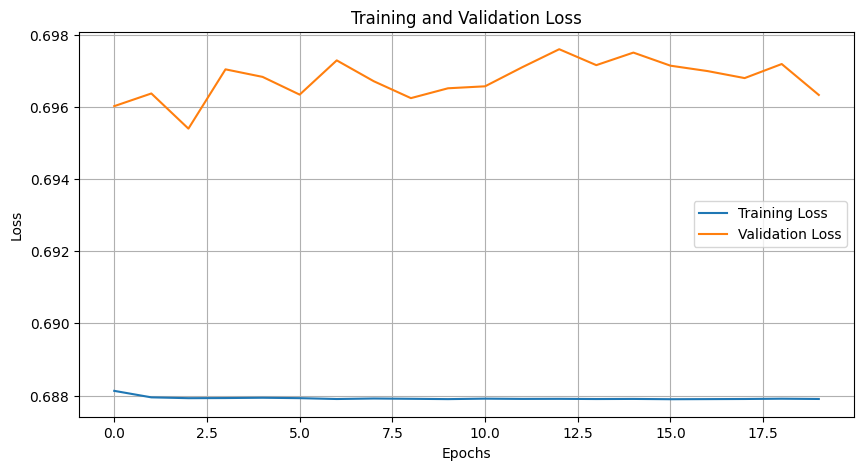

In [ ]:
#plot losses
train_loss = history.history['total_loss']
val_loss = history.history['val_loss']

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


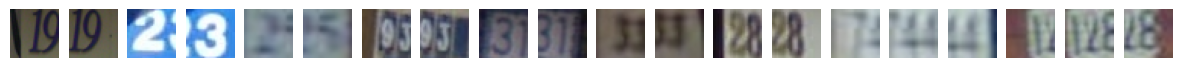

In [ ]:
#print some original images
import matplotlib.pyplot as plt

def display_images(images, n=20):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

display_images(x_train)  # Display first 5 training images


In [ ]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae_model.predict(example_images)
print("Shape of reconstructions:", reconstructions.shape)  # Check the shape

print("Example real images")
display(example_images)
print("Reconstructions")
display(reconstructions)

# Encode the example images
z_mean, z_var, z = vae.encoder.predict(example_images)

# Show the encoded points in 2D space
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.title("Encoded Points in Latent Space")
plt.show()

# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

# Draw a plot of...
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.title("Original and Sampled Points in Latent Space")
plt.show()

# Add grid of decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i])
plt.show()


1/1 [==============================] - 0s 32ms/step


TypeError: Invalid shape (10, 32, 32, 3) for image data

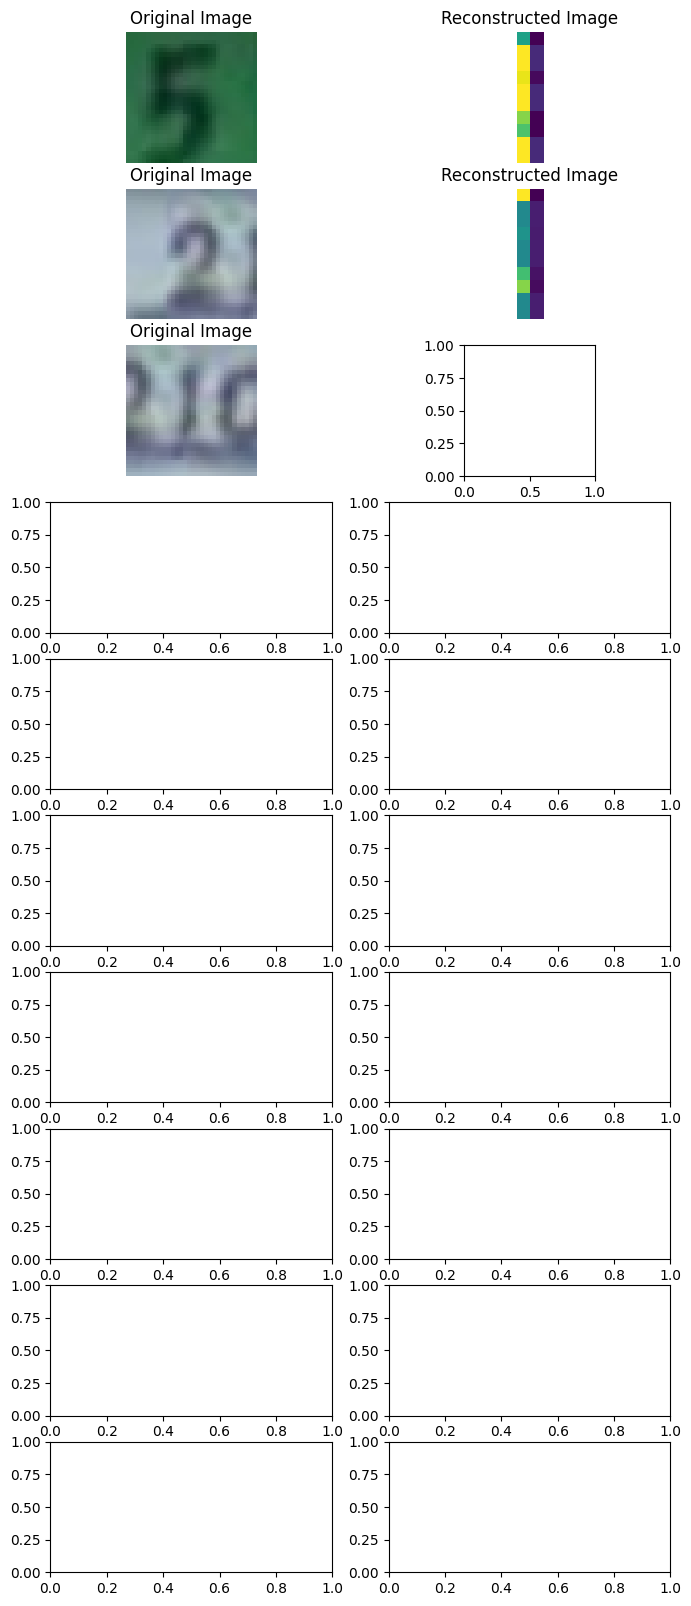

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select a subset of images to visualize
n_to_display = 10
example_images = x_test[:n_to_display]
reconstructions = vae_model.predict(example_images)

# Set up the plot
fig, axes = plt.subplots(n_to_display, 2, figsize=(8, 2 * n_to_display))

for i in range(n_to_display):
    # Display original image
    axes[i, 0].imshow(example_images[i])
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Display reconstructed image
    reconstructed_image = reconstructions[i]
    reconstructed_image = np.clip(reconstructed_image, 0, 1)
    reconstructed_image = (reconstructed_image - np.min(reconstructed_image)) / (np.max(reconstructed_image) - np.min(reconstructed_image) + 1e-8)

    axes[i, 1].imshow(reconstructed_image)
    axes[i, 1].set_title('Reconstructed Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
